# Benchmarking Runge-Kutta Solvers
Benchmark the Runge-Kutta Solvers by solving the equation for a circle:
$
\frac{dx}{dt} = -y, \\ \frac{dy}{dt} = x
$
This is solved using the Explicit (Forward) methods.

The Implicit (Backward) solver works on the equation in Matrix ODE form:
$
\left(\begin{array}{c}
    \frac{dx}{dt}\\
    \frac{dy}{dt}
\end{array}\right)=
\left(\begin{array}{cc}
    0&-1\\
    1&0
\end{array}\right)
\left(\begin{array}{c}
    x\\y
\end{array}\right)
$

This notebook compares the performance of the explicit and implicit methods on this ODE

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
import rungekutta as rk
import numpy as np
import pandas as pd
from plotnine import *
import time

## Setup System
### Equations

In [2]:
def circle_mat(t): # Matrix form for Implicit Solver
    return np.array([[0,-1],[1,0]], dtype=float)

def circle_rhs(y, t): # RHS form for Explicit Solver
    return np.array([-y[1], y[0]], dtype=float)

def circle_analytic(t):
    return np.array([np.cos(t), np.sin(t)], dtype=float)

### Solve Helper

In [3]:
def calculate_error(solver: rk.RKSolver, step_size: float, isImplicit=True):
    times = np.linspace(0, 100, 10)
    t0 = time.perf_counter()
    y = solver.solve_times(times, func=circle_mat if isImplicit else circle_rhs, y0=[1,0], t0=0, step_size=step_size)
    t1 = time.perf_counter()
    sq_err = 0
    for i in range(times.shape[0]):
        err = y[i,:].reshape(-1) - circle_analytic(times[i])
        sq_err += np.inner(err, err)
    return np.sqrt(sq_err / times.shape[0]), t1-t0

## Setup Solvers
### Implicit Solvers

In [4]:
backward_euler = rk.ImplicitSolver([1], [1], [[1]])
midpoint = rk.ImplicitSolver([0.5], [1], [[0.5]])
crank_nicolson = rk.ImplicitSolver([0,1], [0.5,0.5],[[0,0],[0.5,0.5]])
gauss_legendre_4 = rk.ImplicitSolver([1/2-np.sqrt(3)/6, 1/2+np.sqrt(3)/6],[0.5,0.5],
    [[1/4, 1/4-np.sqrt(3)/6],
    [1/4+np.sqrt(3)/6, 1/4]])
gauss_legendre_6 = rk.ImplicitSolver([1/2-np.sqrt(15)/10, 0.5, 1/2+np.sqrt(15)/10],
    [5/18, 4/9, 5/18],
    [[5/36, 2/9-np.sqrt(15)/15, 5/36-np.sqrt(15)/30],
    [5/36+np.sqrt(15)/24, 2/9, 5/36-np.sqrt(15)/24],
    [5/36+np.sqrt(15)/30, 2/9+np.sqrt(15)/15, 5/36]])

implicit_solvers={
    'backward_euler': backward_euler,
    'implicit_midpoint': midpoint,
    'crank_nicolson': crank_nicolson,
    'order_4_gauss_legendre': gauss_legendre_4,
    'order_6_guss_legendre': gauss_legendre_6
}

### Explicit Solvers

In [5]:
forward_euler = rk.ExplicitSolver([0], [1], [[0]])
midpoint = rk.ExplicitSolver([0, 0.5], [0, 1], [[0, 0], [1/2, 0]])
fourth_order = rk.ExplicitSolver([0, 0.5, 0.5, 1], [1/6, 1/3, 1/3, 1/6],
    [[0,0,0,0], [1/2,0,0,0], [0,1/2,0,0], [0,0,1,0]])
dormand_prince = rk.ExplicitSolver([0,1/5,3/10,4/5,8/9,1,1], [35/384,0,500/1113,125/192,-2187/6784,11/84,0],
    [[0,0,0,0,0,0,0],[1/5,0,0,0,0,0,0],[3/40,9/40,0,0,0,0,0],[44/45,-56/15,32/9,0,0,0,0],
    [19372/6561,-25360/2187,64448/6561,-212/729,0,0,0],
    [9017/3168,-355/33,46732/5247,49/176,-5103/18656,0,0],
    [35/384,0,500/1113,125/192,-2187/6784,11/84,0]])

explicit_solvers = {
    'forward_euler': forward_euler,
    'explicit_midpoint': midpoint,
    'fourth_order_runge_kutta': fourth_order,
    'dormand_prince': dormand_prince}

## Perform Solves

In [6]:
df_error = pd.DataFrame(columns=['method', 'step_size', 'rms_error', 'time'])

step_sizes = np.logspace(-3, 0.01, 20)
for step_size in step_sizes:
    for solvers, isImplicit in zip((implicit_solvers, explicit_solvers), (True, False)):
        for solver in solvers:
            print(f'\rSolving using {solver}, step_size {step_size:.2e}' + ' '*50, end='')
            rms_err, t = calculate_error(solvers[solver], step_size, isImplicit=isImplicit)
            df_error = df_error.append(
                {'method': solver, 'step_size': step_size, 'rms_error': rms_err, 'time':t,
                'isImplicit':'Implicit Models' if isImplicit else 'Explicit Models'},
                ignore_index=True)

Solving using dormand_prince, step_size 1.02e+00                                                            

## Plot Results
### Plot Error against Step Size

/home/sabsr3/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


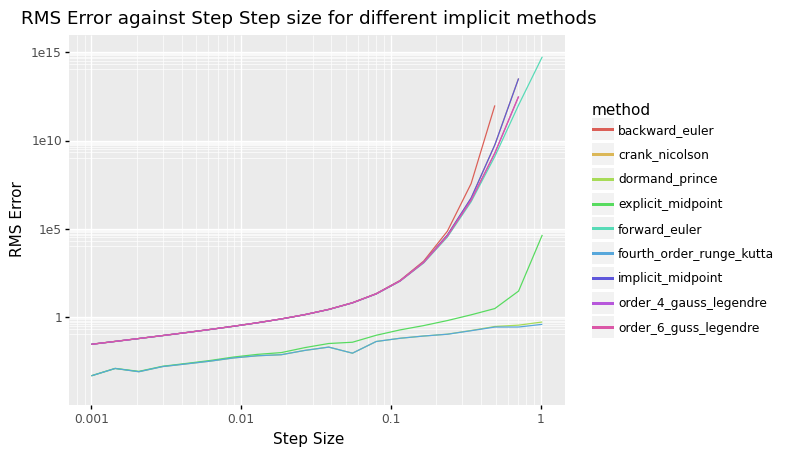

<ggplot: (8790664471197)>

In [7]:
(
    ggplot(df_error) +
    geom_line(aes(x='step_size', y='rms_error', color='method')) +
    #geom_jitter(aes(x='step_size', y='rms_error', color='method'), width=0.01, height=0.01) +
    scale_x_log10() + scale_y_log10(limits=(0.0001, 1e15)) +
    ggtitle('RMS Error against Step Step size for different implicit methods') +
    ylab('RMS Error') + xlab('Step Size')
)

Group by Implicit vs Explicit methods

/home/sabsr3/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


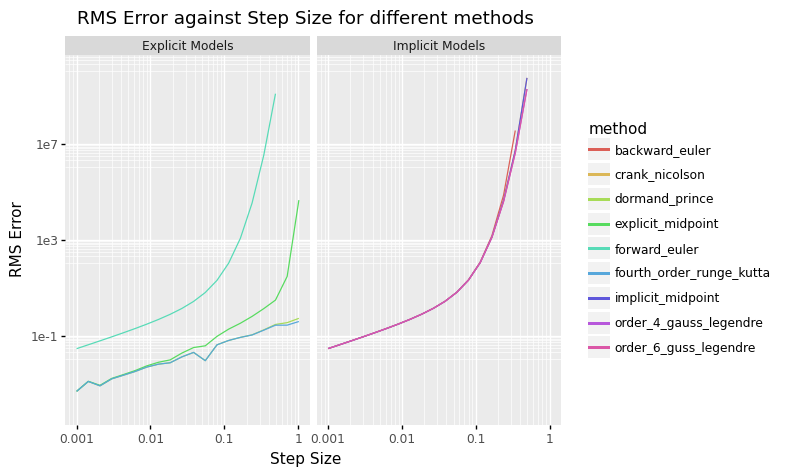

<ggplot: (8790656051975)>

In [12]:
(
    ggplot(df_error) +
    geom_line(aes(x='step_size', y='rms_error', colour='method')) +
    scale_x_log10() + scale_y_log10(limits=(0.0001, 1e10)) + facet_wrap('isImplicit') +
    ggtitle('RMS Error against Step Size for different methods') +
    ylab('RMS Error') + xlab('Step Size')
)

The Explicit and Implicit solvers show very similar error. This is probably since the ODE is well behaved and not stiff. The guaranteed stability of implicit solvers is not important in this system.

### Plot Performance

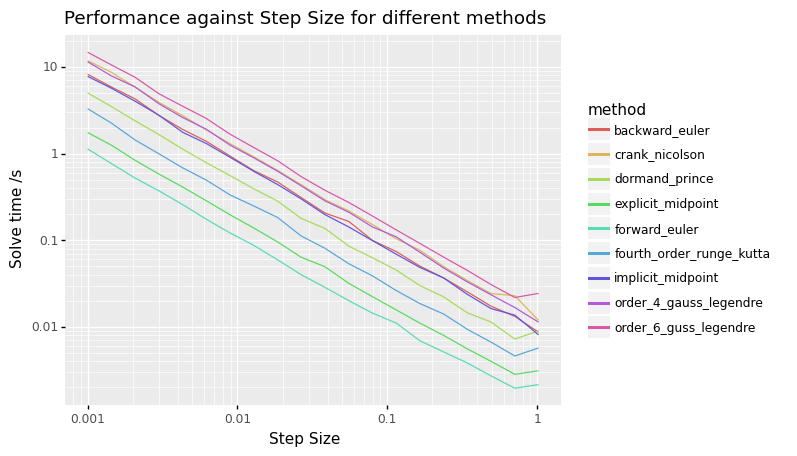

<ggplot: (8790662236420)>

In [10]:
(
    ggplot(df_error) +
    geom_line(aes(x='step_size', y='time', colour='method')) +
    scale_x_log10() + scale_y_log10() +
    ggtitle('Performance against Step Size for different methods') +
    ylab('Solve time /s') + xlab('Step Size')
)

Group by Implicit vs Explicit Methods

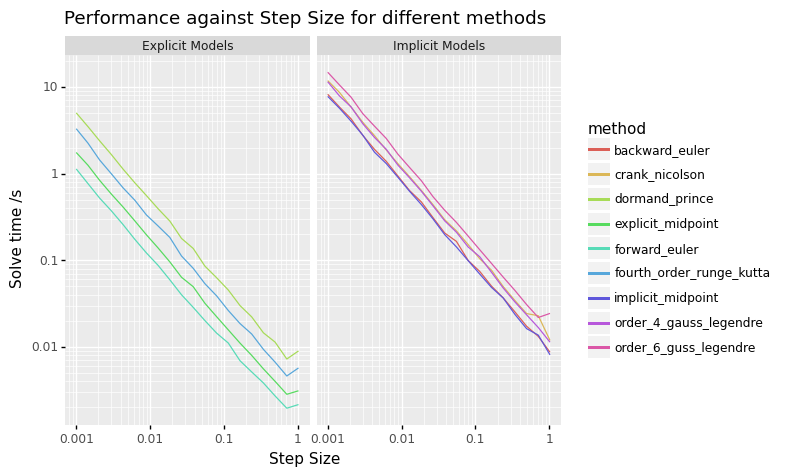

<ggplot: (8790661445913)>

In [11]:
(
    ggplot(df_error) +
    geom_line(aes(x='step_size', y='time', colour='method')) +
    scale_x_log10() + scale_y_log10() + facet_wrap('isImplicit') +
    ggtitle('Performance against Step Size for different methods') +
    ylab('Solve time /s') + xlab('Step Size')
)

Implicit solvers are much slower than explicit methods since implicit methods require a system of linear equations to be solved at every timestep. Explicit systems are simply updated by an expression based on the previous timestep.